In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("D:\\2_Extra\\forage\\QVI\\QVI_data.csv")

In [3]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
df.isna().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [6]:
df['DATE'] = pd.to_datetime(df['DATE'])

df['MONTH_ID'] = df['DATE'].dt.strftime('%Y%m')

In [7]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


## Defining Metrics To Use During Analysis

In [8]:
measure_over_time = df.groupby(['STORE_NBR', 'MONTH_ID']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxn=('TXN_ID', 'nunique'),
    nChips=('PROD_QTY', 'sum')
).reset_index()

In [9]:
# Calculate transactions per customer, chips per transaction, and average price per unit
measure_over_time['nTxnPerCust'] = measure_over_time['nTxn'] / measure_over_time['nCustomers']
measure_over_time['nChipsPerTxn'] = measure_over_time['nChips'] / measure_over_time['nTxn']
measure_over_time['avgPricePerUnit'] = measure_over_time['totSales'] / measure_over_time['nChips']

In [10]:
measure_over_time.drop(['nTxn', 'nChips'], axis=1, inplace=True)
measure_over_time = measure_over_time.sort_values(by=['STORE_NBR', 'MONTH_ID'])

measure_over_time.head()

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


## Filter to the pre-trial period and stores with full observation periods


In [11]:
measure_over_time['MONTH_ID'] = measure_over_time['MONTH_ID'].astype(int)

full_obs_stores = measure_over_time.groupby('STORE_NBR')['MONTH_ID'].nunique()

In [12]:
full_obs_stores

STORE_NBR
1      12
2      12
3      12
4      12
5      12
       ..
268    12
269    12
270    12
271    12
272    12
Name: MONTH_ID, Length: 272, dtype: int64

In [13]:
stores_with_full_obs = full_obs_stores[full_obs_stores == 12].index.tolist()

# Filter the data to only include the pre-trial period for those stores
pre_trial_measures = measure_over_time[
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs)) &
    (measure_over_time['MONTH_ID'] < 201902)
]

In [14]:
pre_trial_measures.head()

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


## Find Stores Similar to Trial Store-77

Correlation between stores

In [15]:
def calculate_correlation(input_table, metric_col, store_comparison):
    # Initialize an empty DataFrame to store results
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])

    # Extracting unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()

    # Filter the data for the trial store
    trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison]

    # Ensure there's enough data to calculate correlation
    if trial_store_data.shape[0] < 2:
        raise ValueError("Not enough data to calculate correlation for the trial store.")

    # Looping through each store number
    for store in store_numbers:
        if store != store_comparison:
            # Filter the data for the control store
            control_store_data = input_table[input_table['STORE_NBR'] == store]

            # Check if there are enough data points for both stores
            if control_store_data.shape[0] < 2:
                print(f"Not enough data to calculate correlation for store {store}.")
                continue

            # Calculate correlation for the metric
            combined_data = pd.merge(trial_store_data, control_store_data, on='MONTH_ID', suffixes=('_trial', '_control'))
            correlation = combined_data[f'{metric_col}_trial'].corr(combined_data[f'{metric_col}_control'])

            # Append the results to the DataFrame
            calc_corr_table = calc_corr_table.append({
                'Store1': store_comparison,
                'Store2': store,
                'corr_measure': correlation
            }, ignore_index=True)

    return calc_corr_table


Magnitude Distance Between Stores

In [16]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = []
    store_numbers = input_table['STORE_NBR'].unique()
    
    for store in store_numbers:
        if store != store_comparison:
            for month in input_table['MONTH_ID'].unique():
                # Calculating absolute difference
                trial_store_value = input_table[(input_table['STORE_NBR'] == store_comparison) & (input_table['MONTH_ID'] == month)][metric_col].values[0]
                control_store_value = input_table[(input_table['STORE_NBR'] == store) & (input_table['MONTH_ID'] == month)][metric_col].values[0]
                measure = abs(trial_store_value - control_store_value)
                # Appending results
                calc_dist_table.append({'Store1': store_comparison, 'Store2': store, 'MONTH_ID': month, 'measure': measure})
    
    # Standardizing the magnitude distance
    calc_dist_table = pd.DataFrame(calc_dist_table)
    for month in calc_dist_table['MONTH_ID'].unique():
        min_dist = calc_dist_table[calc_dist_table['MONTH_ID'] == month]['measure'].min()
        max_dist = calc_dist_table[calc_dist_table['MONTH_ID'] == month]['measure'].max()
        calc_dist_table.loc[calc_dist_table['MONTH_ID'] == month, 'magnitudeMeasure'] = 1 - (calc_dist_table['measure'] - min_dist) / (max_dist - min_dist)
    
    final_dist_table = calc_dist_table.groupby(['Store1', 'Store2']).agg(mag_measure=('magnitudeMeasure', 'mean')).reset_index()
    return final_dist_table

In [17]:
trial_store_number = 77

# Use the functions to calculate correlations for total sales and number of customers
corr_tot_sales = calculate_correlation(pre_trial_measures, 'totSales', trial_store_number)
corr_n_customers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store_number)

# Use the functions to calculate magnitude distances for total sales and number of customers
magnitude_tot_sales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store_number)
magnitude_n_customers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store_number)

In [18]:
corr_tot_sales

,Store1,Store2,corr_measure
0,77.0,1.0,0.075218
1,77.0,2.0,-0.263079
2,77.0,3.0,0.806644
3,77.0,4.0,-0.263300
4,77.0,5.0,-0.110652
...,...,...,...
254,77.0,268.0,0.344757
255,77.0,269.0,-0.315730
256,77.0,270.0,0.315430
257,77.0,271.0,0.355487


Average Score to Rank Control Stores

In [19]:
score_tot_sales = pd.merge(corr_tot_sales, magnitude_tot_sales, on=['Store1', 'Store2'])
score_tot_sales['scoreTotalSales'] = 0.5 * score_tot_sales['corr_measure'] + 0.5 * score_tot_sales['mag_measure']

score_n_customers = pd.merge(corr_n_customers, magnitude_n_customers, on=['Store1', 'Store2'])
score_n_customers['scoreNCustomers'] = 0.5 * score_n_customers['corr_measure'] + 0.5 * score_n_customers['mag_measure']

# Combining scores
final_score = pd.merge(score_tot_sales[['Store1', 'Store2', 'scoreTotalSales']], score_n_customers[['Store1', 'Store2', 'scoreNCustomers']], on=['Store1', 'Store2'])
final_score['finalControlScore'] = 0.5 * final_score['scoreTotalSales'] + 0.5 * final_score['scoreNCustomers']

In [20]:
final_score

,Store1,Store2,scoreTotalSales,scoreNCustomers,finalControlScore
0,77.0,1.0,0.515139,0.631244,0.573192
1,77.0,2.0,0.338120,0.176294,0.257207
2,77.0,3.0,0.580803,0.589637,0.585220
3,77.0,4.0,-0.042943,-0.053030,-0.047986
4,77.0,5.0,0.221707,0.425929,0.323818
...,...,...,...,...,...
254,77.0,268.0,0.653660,0.654712,0.654186
255,77.0,269.0,0.068586,-0.065373,0.001607
256,77.0,270.0,0.381211,0.113233,0.247222
257,77.0,271.0,0.454396,0.251543,0.352969


Selecting The one with the highest Average Score

In [21]:
control_store_selection = final_score[final_score['Store2'] != trial_store_number].sort_values(by='finalControlScore', ascending=False).head(1)['Store2'].values[0]
print(f"The selected control store for trial store {trial_store_number} is store number {control_store_selection}.")

The selected control store for trial store 77 is store number 233.0.


In [22]:
final_score[final_score['Store2']==233]

,Store1,Store2,scoreTotalSales,scoreNCustomers,finalControlScore
220,77.0,233.0,0.945433,0.991566,0.968499


## Comparing The Trial Store To The Contol Store

## Pre Trial Period

Comparing Total Sales

In [23]:
trial_store = 77
control_store = 233

trial_and_control_data = measure_over_time[(measure_over_time['STORE_NBR'] == trial_store) | 
                                           (measure_over_time['STORE_NBR'] == control_store)]

# Further filter the data to only include the pre-trial period
pre_trial_data = trial_and_control_data[trial_and_control_data['MONTH_ID'] < 201902]

# Group by MONTH_ID and STORE_NBR and calculate mean total sales
grouped_sales = pre_trial_data.groupby(['MONTH_ID', 'STORE_NBR'])['totSales'].mean().reset_index()

# Convert MONTH_ID to datetime for plotting
grouped_sales['MONTH_ID'] = pd.to_datetime(grouped_sales['MONTH_ID'], format='%Y%m')

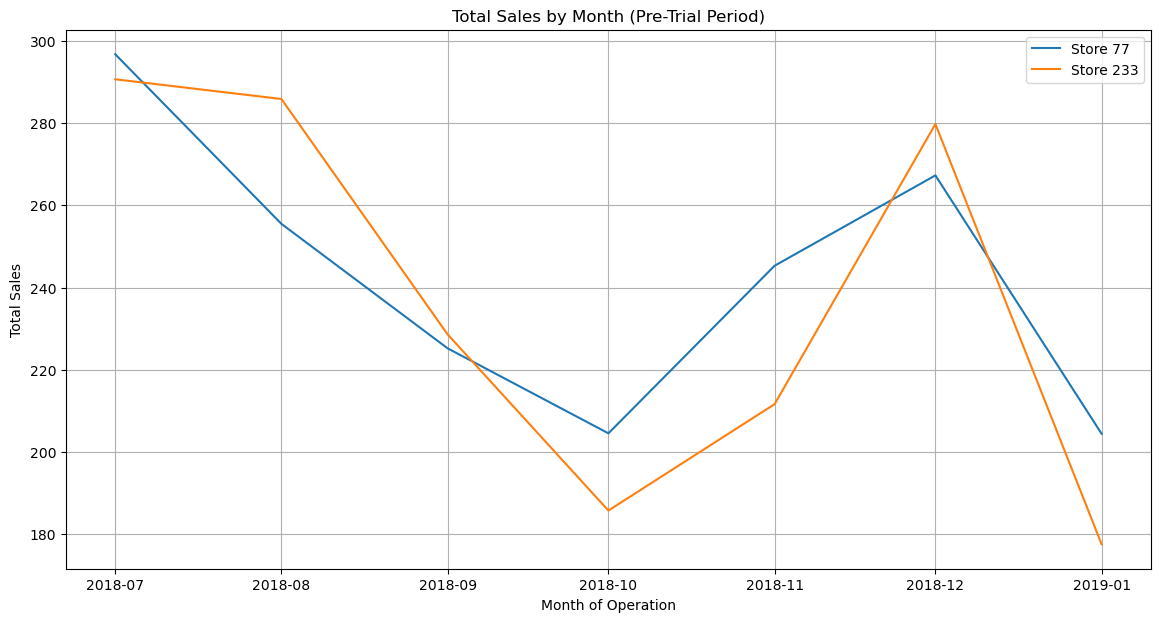

In [24]:
plt.figure(figsize=(14, 7))
for store in [trial_store, control_store]:
    plt.plot('MONTH_ID', 'totSales', 
             data=grouped_sales[grouped_sales['STORE_NBR'] == store], 
             marker='', label=f"Store {store}")

plt.title('Total Sales by Month (Pre-Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

Comparing Number Of Customers

In [25]:
# Group by MONTH_ID and STORE_NBR and calculate mean total customers
grouped_ncustomers = pre_trial_data.groupby(['MONTH_ID', 'STORE_NBR'])['nCustomers'].mean().reset_index()

# Convert MONTH_ID to datetime for plotting
grouped_ncustomers['MONTH_ID'] = pd.to_datetime(grouped_ncustomers['MONTH_ID'], format='%Y%m')

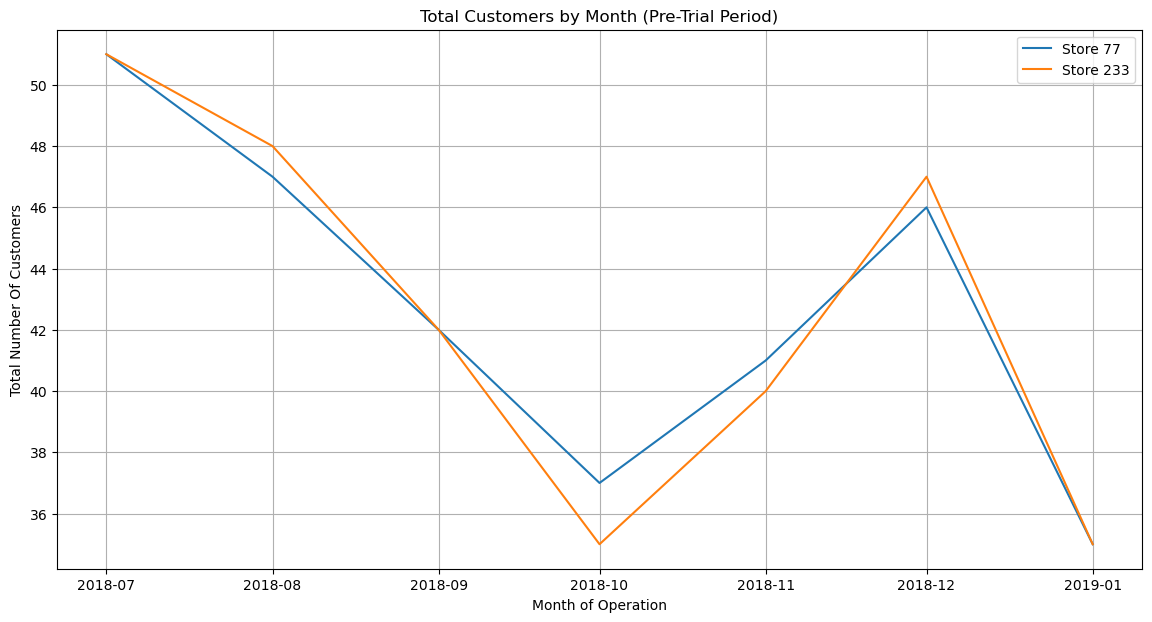

In [26]:
plt.figure(figsize=(14, 7))
for store in [trial_store, control_store]:
    plt.plot('MONTH_ID', 'nCustomers', 
             data=grouped_ncustomers[grouped_ncustomers['STORE_NBR'] == store], 
             marker='', label=f"Store {store}")

plt.title('Total Customers by Month (Pre-Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number Of Customers')
plt.legend()
plt.grid(True)
plt.show()

## Trial Period

## Total Sales

Scale Pre Trial Control Sales

In [27]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['totSales'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['totSales'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['totSales'] * scaling_factor if x['STORE_NBR'] == control_store else x['totSales'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [28]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [29]:
merged_sales.head(10)

STORE_NBR,77,233,percentageDiff
MONTH_ID,,,
201807,296.8,297.565550,-0.257271
201808,255.5,292.652187,-12.694997
201809,225.2,233.998916,-3.760238
201810,204.5,190.085733,7.583035
201811,245.3,216.597421,13.251579
201812,267.3,286.408121,-6.671641
201901,204.4,181.692071,12.498029
201902,235.0,249.762622,-5.910661
201903,278.5,203.802205,36.652103


T-test For Trial Month

In [30]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,3.680430,1.894579
201904,201904,6.256669,1.894579


We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.

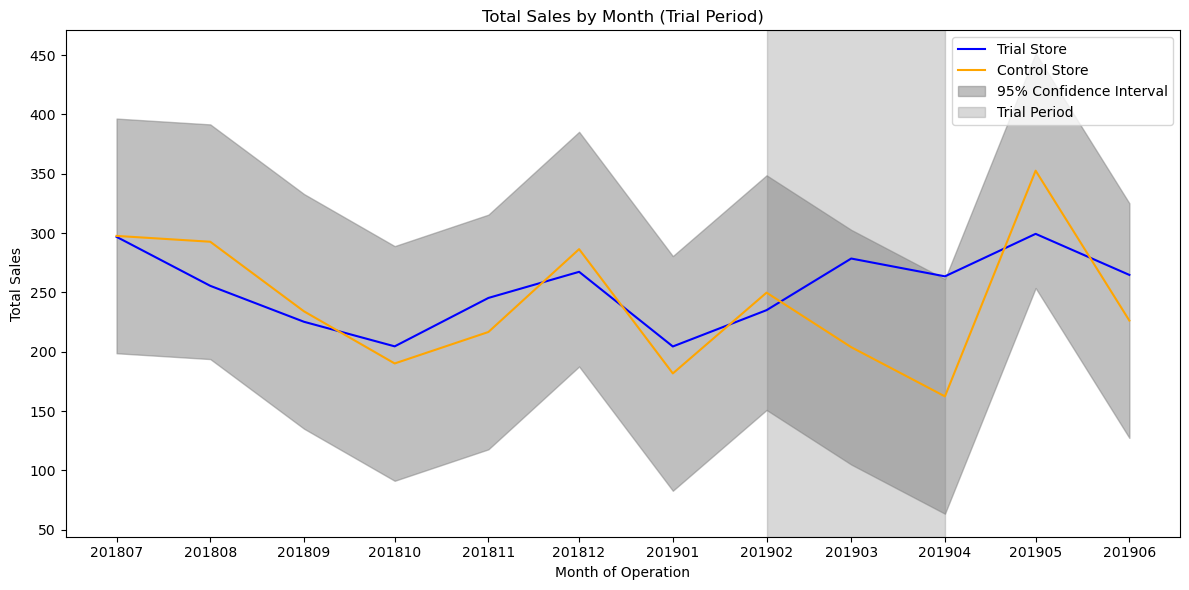

In [31]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['totSales'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['totSales'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['totSales'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['totSales'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Sales by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in one of the three trial
months.

## Total Customers

Scale Pre Trial Total Customers

In [32]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['nCustomers'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['nCustomers'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['nCustomers'] * scaling_factor if x['STORE_NBR'] == control_store else x['nCustomers'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [33]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [34]:
merged_sales.head(10)

STORE_NBR,77,233,percentageDiff
MONTH_ID,,,
201807,51.0,51.171141,-0.334448
201808,47.0,48.161074,-2.410814
201809,42.0,42.140940,-0.334448
201810,37.0,35.117450,5.360726
201811,41.0,40.134228,2.157191
201812,46.0,47.157718,-2.454992
201901,35.0,35.117450,-0.334448
201902,45.0,45.151007,-0.334448
201903,50.0,40.134228,24.581940


T-test For Trial Month

In [35]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,8.958446,1.894579
201904,201904,20.460197,1.894579


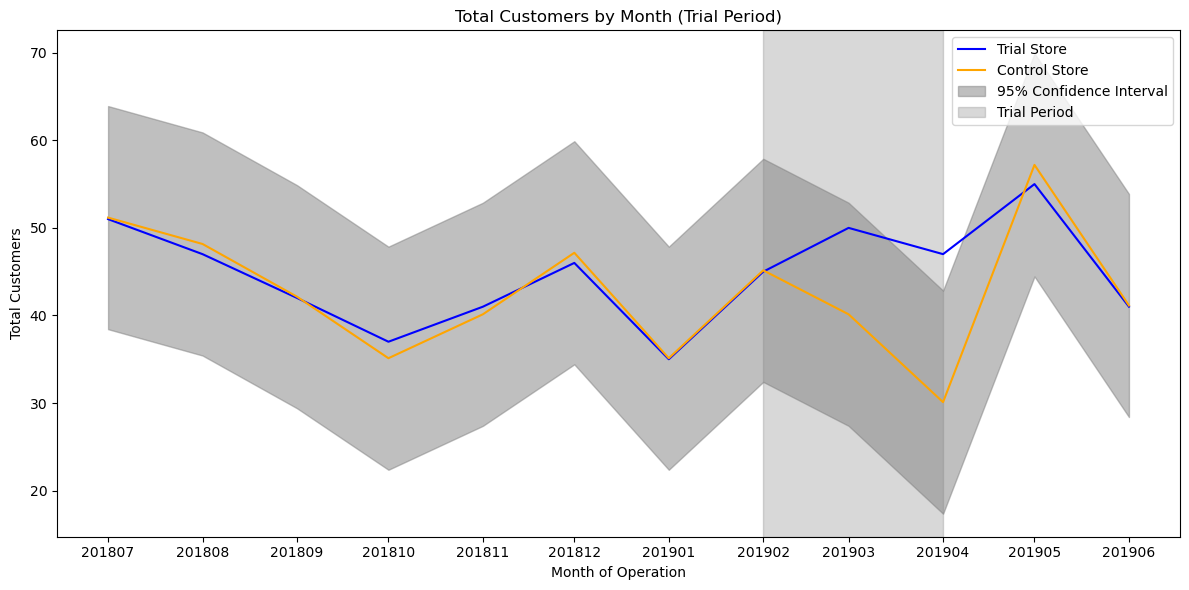

In [36]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['nCustomers'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['nCustomers'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['nCustomers'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['nCustomers'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Customers by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Customers')
plt.legend()
plt.tight_layout()
plt.show()


## Find Stores Similar to Trial Store-88

In [37]:
trial_store_number = 88

# Use the functions to calculate correlations for total sales and number of customers
corr_tot_sales = calculate_correlation(pre_trial_measures, 'totSales', trial_store_number)
corr_n_customers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store_number)

# Use the functions to calculate magnitude distances for total sales and number of customers
magnitude_tot_sales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store_number)
magnitude_n_customers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store_number)

In [38]:
corr_tot_sales

,Store1,Store2,corr_measure
0,88.0,1.0,0.813636
1,88.0,2.0,-0.067927
2,88.0,3.0,-0.507847
3,88.0,4.0,-0.745566
4,88.0,5.0,0.190330
...,...,...,...
254,88.0,268.0,-0.021429
255,88.0,269.0,-0.172578
256,88.0,270.0,-0.723272
257,88.0,271.0,-0.103037


Average Score to Rank Control Stores

In [39]:
score_tot_sales = pd.merge(corr_tot_sales, magnitude_tot_sales, on=['Store1', 'Store2'])
score_tot_sales['scoreTotalSales'] = 0.5 * score_tot_sales['corr_measure'] + 0.5 * score_tot_sales['mag_measure']

score_n_customers = pd.merge(corr_n_customers, magnitude_n_customers, on=['Store1', 'Store2'])
score_n_customers['scoreNCustomers'] = 0.5 * score_n_customers['corr_measure'] + 0.5 * score_n_customers['mag_measure']

# Combining scores
final_score = pd.merge(score_tot_sales[['Store1', 'Store2', 'scoreTotalSales']], score_n_customers[['Store1', 'Store2', 'scoreNCustomers']], on=['Store1', 'Store2'])
final_score['finalControlScore'] = 0.5 * final_score['scoreTotalSales'] + 0.5 * final_score['scoreNCustomers']

In [40]:
final_score

,Store1,Store2,scoreTotalSales,scoreNCustomers,finalControlScore
0,88.0,1.0,0.478544,0.329501,0.404023
1,88.0,2.0,0.024214,-0.075045,-0.025415
2,88.0,3.0,0.149108,0.686095,0.417602
3,88.0,4.0,0.077909,0.284713,0.181311
4,88.0,5.0,0.401472,0.358403,0.379938
...,...,...,...,...,...
254,88.0,268.0,0.070092,0.505273,0.287682
255,88.0,269.0,0.270075,0.288909,0.279492
256,88.0,270.0,-0.002811,0.368020,0.182604
257,88.0,271.0,0.256460,0.362145,0.309303


Selecting The one with the highest Average Score

In [41]:
control_store_selection = final_score[final_score['Store2'] != trial_store_number].sort_values(by='finalControlScore', ascending=False).head(1)['Store2'].values[0]
print(f"The selected control store for trial store {trial_store_number} is store number {control_store_selection}.")

The selected control store for trial store 88 is store number 237.0.


In [42]:
final_score[final_score['Store2']==237]

,Store1,Store2,scoreTotalSales,scoreNCustomers,finalControlScore
224,88.0,237.0,0.634245,0.970805,0.802525


## Comparing The Trial Store To The Contol Store

## Pre Trial Period

Comparing Total Sales

In [43]:
trial_store = 88
control_store = 237

trial_and_control_data = measure_over_time[(measure_over_time['STORE_NBR'] == trial_store) | 
                                           (measure_over_time['STORE_NBR'] == control_store)]

# Further filter the data to only include the pre-trial period
pre_trial_data = trial_and_control_data[trial_and_control_data['MONTH_ID'] < 201902]

# Group by MONTH_ID and STORE_NBR and calculate mean total sales
grouped_sales = pre_trial_data.groupby(['MONTH_ID', 'STORE_NBR'])['totSales'].mean().reset_index()

# Convert MONTH_ID to datetime for plotting
grouped_sales['MONTH_ID'] = pd.to_datetime(grouped_sales['MONTH_ID'], format='%Y%m')

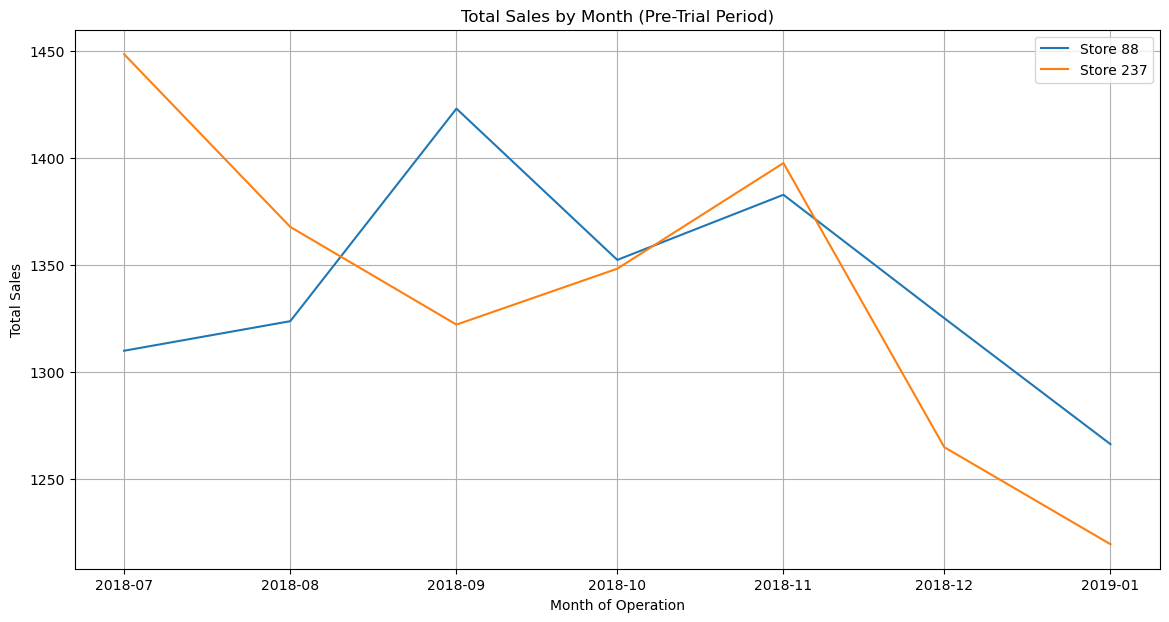

In [44]:
plt.figure(figsize=(14, 7))
for store in [trial_store, control_store]:
    plt.plot('MONTH_ID', 'totSales', 
             data=grouped_sales[grouped_sales['STORE_NBR'] == store], 
             marker='', label=f"Store {store}")

plt.title('Total Sales by Month (Pre-Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

Comparing Number Of Customers

In [45]:
# Group by MONTH_ID and STORE_NBR and calculate mean total customers
grouped_ncustomers = pre_trial_data.groupby(['MONTH_ID', 'STORE_NBR'])['nCustomers'].mean().reset_index()

# Convert MONTH_ID to datetime for plotting
grouped_ncustomers['MONTH_ID'] = pd.to_datetime(grouped_ncustomers['MONTH_ID'], format='%Y%m')

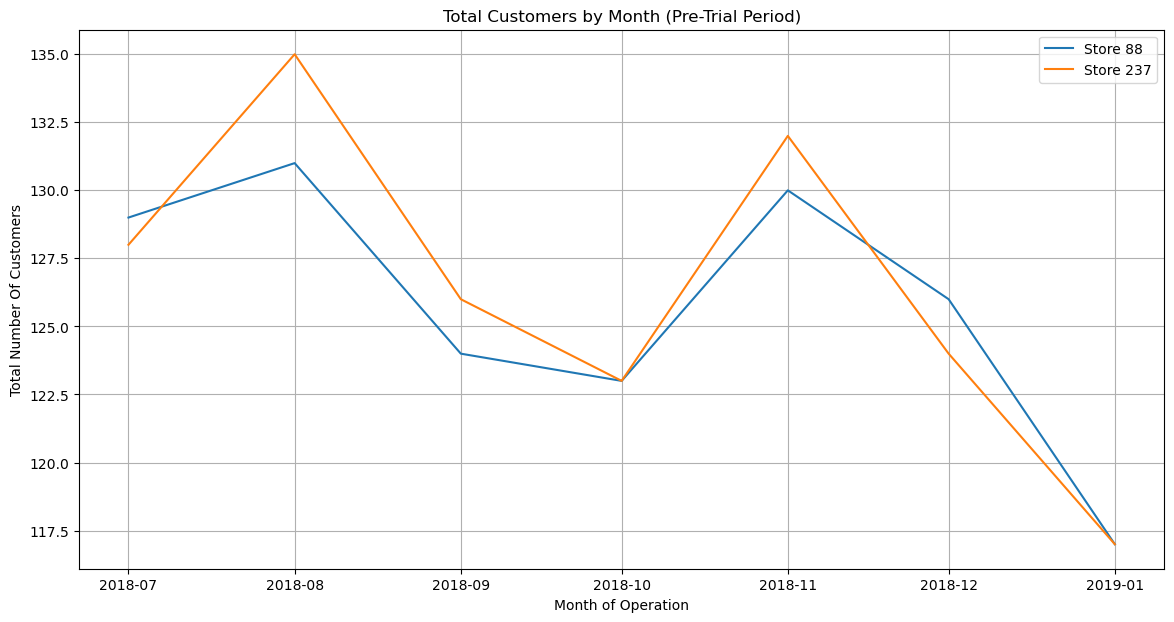

In [46]:
plt.figure(figsize=(14, 7))
for store in [trial_store, control_store]:
    plt.plot('MONTH_ID', 'nCustomers', 
             data=grouped_ncustomers[grouped_ncustomers['STORE_NBR'] == store], 
             marker='', label=f"Store {store}")

plt.title('Total Customers by Month (Pre-Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number Of Customers')
plt.legend()
plt.grid(True)
plt.show()

## Trial Period

Scale Pre Trial Control Sales

In [47]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['totSales'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['totSales'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['totSales'] * scaling_factor if x['STORE_NBR'] == control_store else x['totSales'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [48]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [49]:
merged_sales.head(10)

STORE_NBR,88,237,percentageDiff
MONTH_ID,,,
201807,1310.0,1450.657086,-9.696095
201808,1323.8,1369.931485,-3.367430
201809,1423.0,1324.260425,7.456205
201810,1352.4,1350.401097,0.148023
201811,1382.8,1399.777923,-1.212901
201812,1325.2,1266.971288,4.595898
201901,1266.4,1221.600696,3.667262
201902,1370.2,1406.989143,-2.614742
201903,1477.2,1210.082775,22.074294


T-test For Trial Month

In [50]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,3.855795,1.894579
201904,201904,3.372253,1.894579


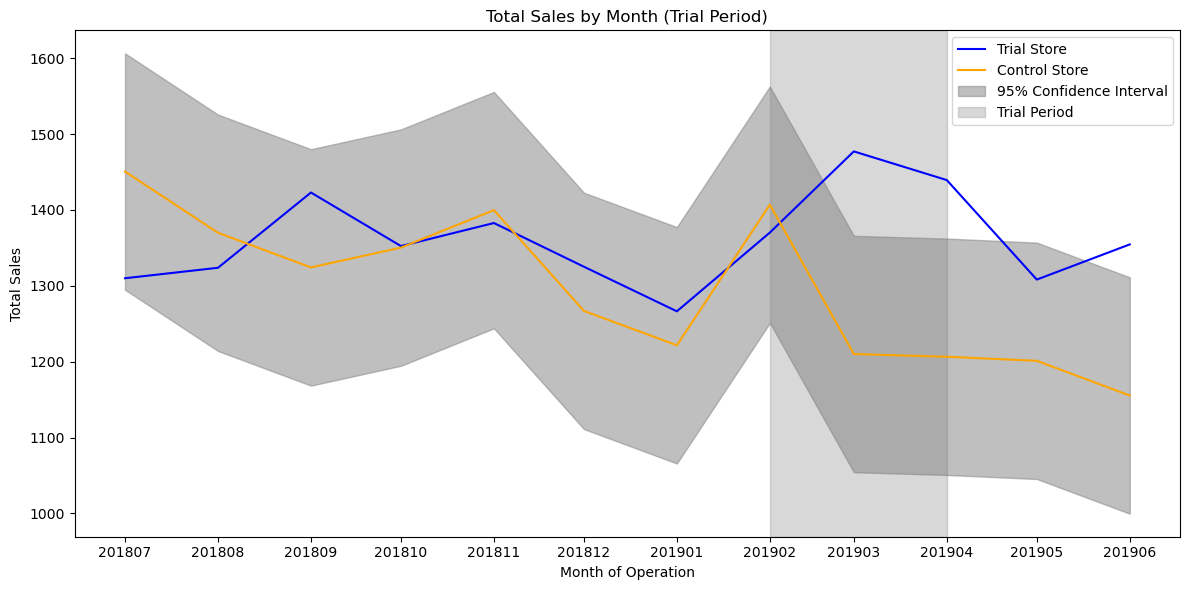

In [51]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['totSales'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['totSales'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['totSales'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['totSales'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Sales by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


The results show that the trial in store 86 is  significantly different to its
control store in the trial period as the trial store performance lies outside the 5%
to 95% confidence interval of the control store in two of the three trial months.


## Total Sales

Scale Pre Trial Control Sales

In [52]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['totSales'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['totSales'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['totSales'] * scaling_factor if x['STORE_NBR'] == control_store else x['totSales'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [53]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [54]:
merged_sales.head(10)

STORE_NBR,88,237,percentageDiff
MONTH_ID,,,
201807,1310.0,1450.657086,-9.696095
201808,1323.8,1369.931485,-3.367430
201809,1423.0,1324.260425,7.456205
201810,1352.4,1350.401097,0.148023
201811,1382.8,1399.777923,-1.212901
201812,1325.2,1266.971288,4.595898
201901,1266.4,1221.600696,3.667262
201902,1370.2,1406.989143,-2.614742
201903,1477.2,1210.082775,22.074294


T-test For Trial Month

In [55]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,3.855795,1.894579
201904,201904,3.372253,1.894579


We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.

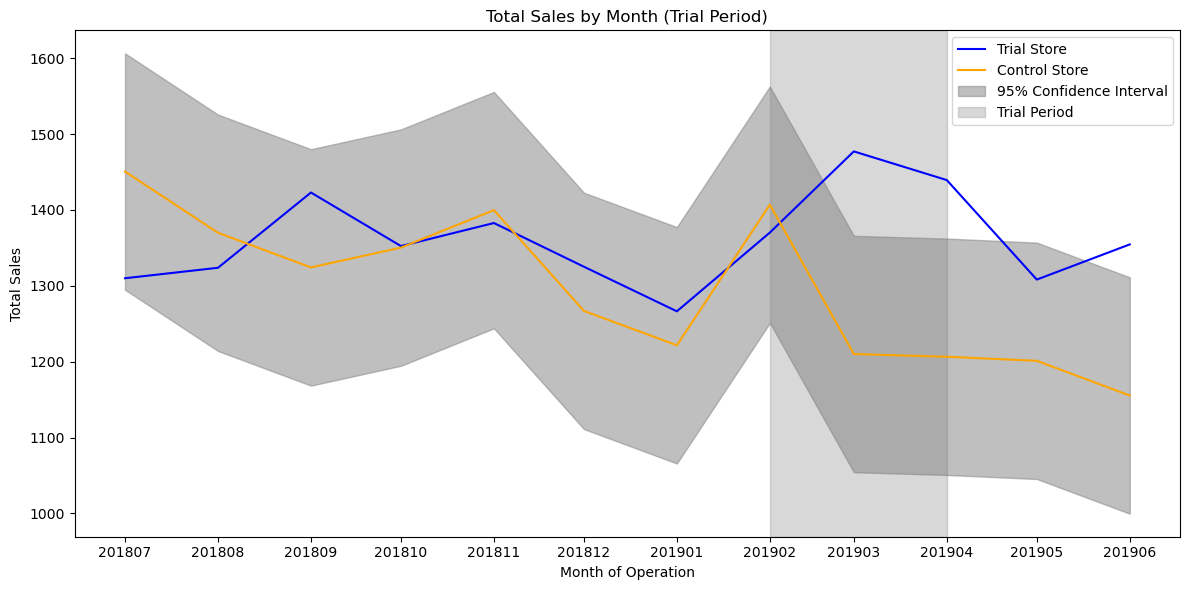

In [56]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['totSales'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['totSales'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['totSales'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['totSales'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Sales by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in one of the three trial
months.

## Total Customers

Scale Pre Trial Total Customers

In [57]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['nCustomers'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['nCustomers'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['nCustomers'] * scaling_factor if x['STORE_NBR'] == control_store else x['nCustomers'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [58]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [59]:
merged_sales.head(10)

STORE_NBR,88,237,percentageDiff
MONTH_ID,,,
201807,129.0,127.276836,1.353871
201808,131.0,134.237288,-2.411616
201809,124.0,125.288136,-1.028139
201810,123.0,122.305085,0.568182
201811,130.0,131.254237,-0.955579
201812,126.0,123.299435,2.190249
201901,117.0,116.338983,0.568182
201902,124.0,125.288136,-1.028139
201903,134.0,118.327684,13.244843


T-test For Trial Month

In [60]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,8.362766,1.894579
201904,201904,4.591985,1.894579


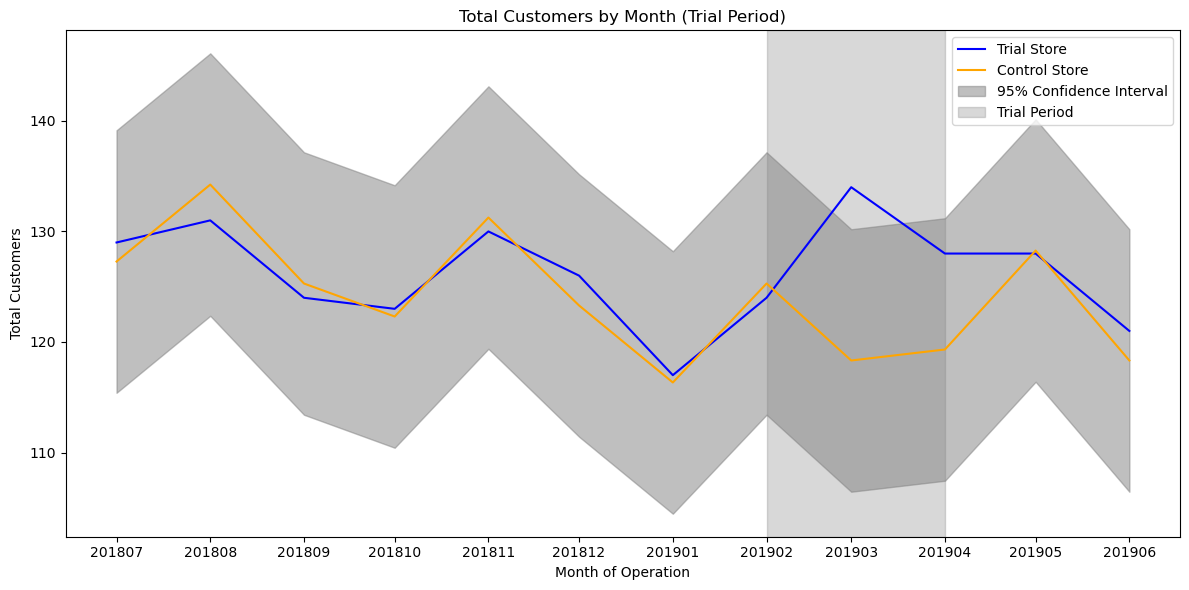

In [61]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['nCustomers'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['nCustomers'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['nCustomers'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['nCustomers'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Customers by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Customers')
plt.legend()
plt.tight_layout()
plt.show()


## Find Stores Similar to Trial Store-86

In [62]:
trial_store_number = 86

# Use the functions to calculate correlations for total sales and number of customers
corr_tot_sales = calculate_correlation(pre_trial_measures, 'totSales', trial_store_number)
corr_n_customers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store_number)

# Use the functions to calculate magnitude distances for total sales and number of customers
magnitude_tot_sales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store_number)
magnitude_n_customers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store_number)

In [63]:
corr_tot_sales

,Store1,Store2,corr_measure
0,86.0,1.0,0.445632
1,86.0,2.0,-0.403835
2,86.0,3.0,-0.261284
3,86.0,4.0,-0.039035
4,86.0,5.0,0.235159
...,...,...,...
254,86.0,268.0,-0.452182
255,86.0,269.0,0.697055
256,86.0,270.0,-0.730679
257,86.0,271.0,0.527637


Average Score to Rank Control Stores

In [64]:
score_tot_sales = pd.merge(corr_tot_sales, magnitude_tot_sales, on=['Store1', 'Store2'])
score_tot_sales['scoreTotalSales'] = 0.5 * score_tot_sales['corr_measure'] + 0.5 * score_tot_sales['mag_measure']

score_n_customers = pd.merge(corr_n_customers, magnitude_n_customers, on=['Store1', 'Store2'])
score_n_customers['scoreNCustomers'] = 0.5 * score_n_customers['corr_measure'] + 0.5 * score_n_customers['mag_measure']

# Combining scores
final_score = pd.merge(score_tot_sales[['Store1', 'Store2', 'scoreTotalSales']], score_n_customers[['Store1', 'Store2', 'scoreNCustomers']], on=['Store1', 'Store2'])
final_score['finalControlScore'] = 0.5 * final_score['scoreTotalSales'] + 0.5 * final_score['scoreNCustomers']

In [65]:
final_score

,Store1,Store2,scoreTotalSales,scoreNCustomers,finalControlScore
0,86.0,1.0,0.333099,0.465214,0.399156
1,86.0,2.0,-0.112097,0.147230,0.017566
2,86.0,3.0,0.250805,0.279032,0.264919
3,86.0,4.0,0.229745,0.302157,0.265951
4,86.0,5.0,0.582240,0.336640,0.459440
...,...,...,...,...,...
254,86.0,268.0,-0.100681,0.196558,0.047938
255,86.0,269.0,0.799548,0.409248,0.604398
256,86.0,270.0,0.051921,0.061611,0.056766
257,86.0,271.0,0.725278,0.601644,0.663461


Selecting The one with the highest Average Score

In [66]:
control_store_selection = final_score[final_score['Store2'] != trial_store_number].sort_values(by='finalControlScore', ascending=False).head(1)['Store2'].values[0]
print(f"The selected control store for trial store {trial_store_number} is store number {control_store_selection}.")

The selected control store for trial store 86 is store number 155.0.


In [67]:
final_score[final_score['Store2']==155]

,Store1,Store2,scoreTotalSales,scoreNCustomers,finalControlScore
146,86.0,155.0,0.921332,0.963956,0.942644


## Comparing The Trial Store To The Contol Store

## Pre Trial Period

Comparing Total Sales

In [68]:
trial_store = 86
control_store = 155

trial_and_control_data = measure_over_time[(measure_over_time['STORE_NBR'] == trial_store) | 
                                           (measure_over_time['STORE_NBR'] == control_store)]

# Further filter the data to only include the pre-trial period
pre_trial_data = trial_and_control_data[trial_and_control_data['MONTH_ID'] < 201902]

# Group by MONTH_ID and STORE_NBR and calculate mean total sales
grouped_sales = pre_trial_data.groupby(['MONTH_ID', 'STORE_NBR'])['totSales'].mean().reset_index()

# Convert MONTH_ID to datetime for plotting
grouped_sales['MONTH_ID'] = pd.to_datetime(grouped_sales['MONTH_ID'], format='%Y%m')

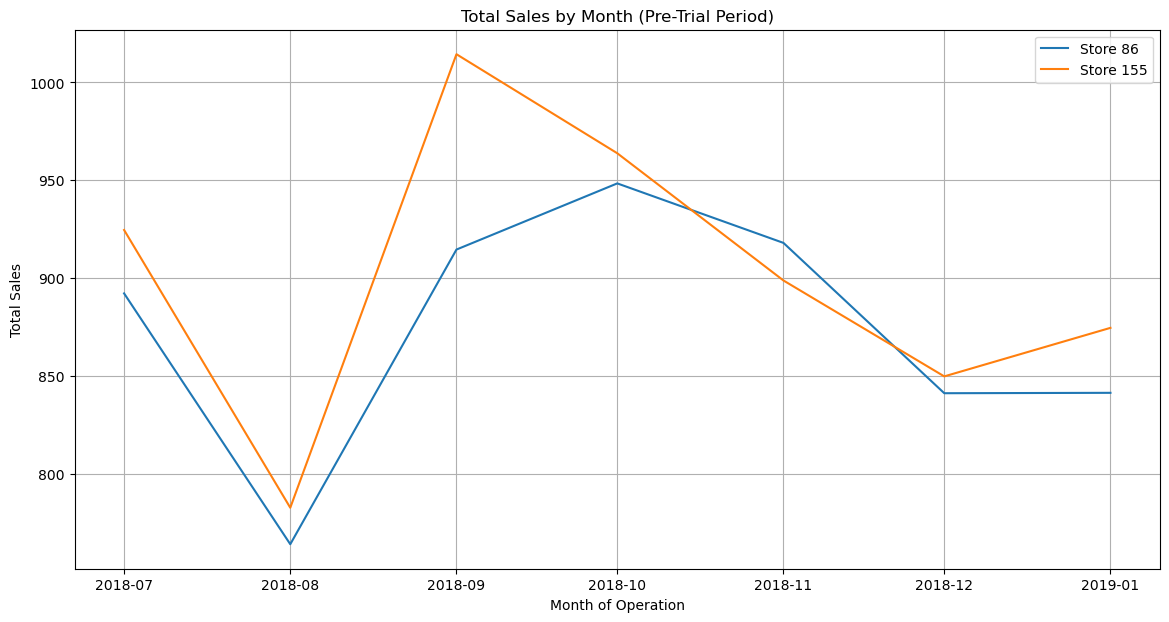

In [69]:
plt.figure(figsize=(14, 7))
for store in [trial_store, control_store]:
    plt.plot('MONTH_ID', 'totSales', 
             data=grouped_sales[grouped_sales['STORE_NBR'] == store], 
             marker='', label=f"Store {store}")

plt.title('Total Sales by Month (Pre-Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

Comparing Number Of Customers

In [70]:
# Group by MONTH_ID and STORE_NBR and calculate mean total customers
grouped_ncustomers = pre_trial_data.groupby(['MONTH_ID', 'STORE_NBR'])['nCustomers'].mean().reset_index()

# Convert MONTH_ID to datetime for plotting
grouped_ncustomers['MONTH_ID'] = pd.to_datetime(grouped_ncustomers['MONTH_ID'], format='%Y%m')

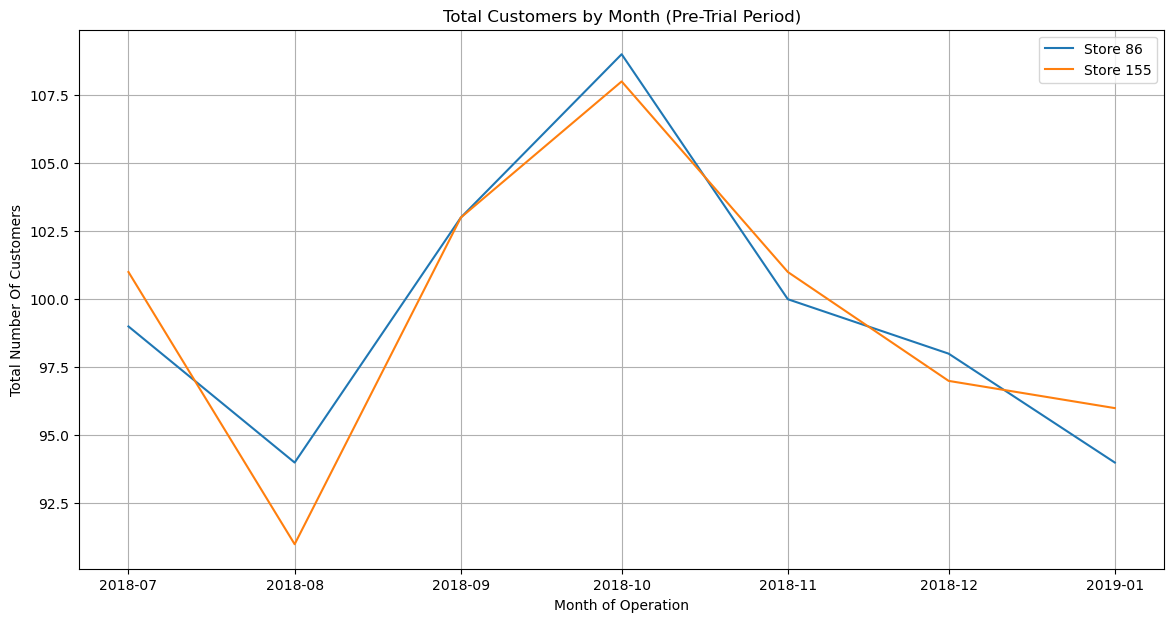

In [71]:
plt.figure(figsize=(14, 7))
for store in [trial_store, control_store]:
    plt.plot('MONTH_ID', 'nCustomers', 
             data=grouped_ncustomers[grouped_ncustomers['STORE_NBR'] == store], 
             marker='', label=f"Store {store}")

plt.title('Total Customers by Month (Pre-Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number Of Customers')
plt.legend()
plt.grid(True)
plt.show()

## Trial Period

Scale Pre Trial Control Sales

In [72]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['totSales'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['totSales'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['totSales'] * scaling_factor if x['STORE_NBR'] == control_store else x['totSales'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [73]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [74]:
merged_sales.head(10)

STORE_NBR,86,155,percentageDiff
MONTH_ID,,,
201807,892.20,896.922236,-0.526493
201808,764.05,759.269991,0.629553
201809,914.60,984.034086,-7.056065
201810,948.40,934.948790,1.438711
201811,918.00,871.894555,5.287961
201812,841.20,824.361363,2.042628
201901,841.40,848.418979,-0.827301
201902,913.20,864.522060,5.630619
201903,1026.80,780.320405,31.586973


T-test For Trial Month

In [75]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,8.381769,1.894579
201904,201904,0.935444,1.894579


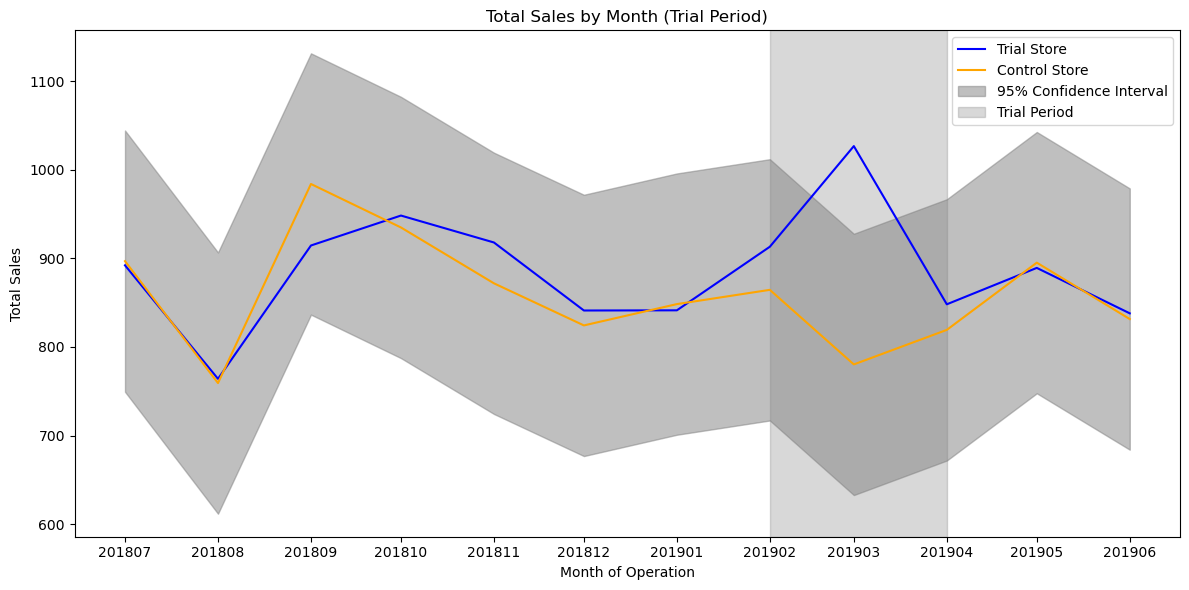

In [76]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['totSales'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['totSales'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['totSales'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['totSales'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Sales by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


The results show that the trial in store 86 is not significantly different to its
control store in the trial period as the trial store performance lies inside the 5%
to 95% confidence interval of the control store in two of the three trial months.


## Total Sales

Scale Pre Trial Control Sales

In [77]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['totSales'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['totSales'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['totSales'] * scaling_factor if x['STORE_NBR'] == control_store else x['totSales'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [78]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [79]:
merged_sales.head(10)

STORE_NBR,86,155,percentageDiff
MONTH_ID,,,
201807,892.20,896.922236,-0.526493
201808,764.05,759.269991,0.629553
201809,914.60,984.034086,-7.056065
201810,948.40,934.948790,1.438711
201811,918.00,871.894555,5.287961
201812,841.20,824.361363,2.042628
201901,841.40,848.418979,-0.827301
201902,913.20,864.522060,5.630619
201903,1026.80,780.320405,31.586973


T-test For Trial Month

In [80]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,8.381769,1.894579
201904,201904,0.935444,1.894579


We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.

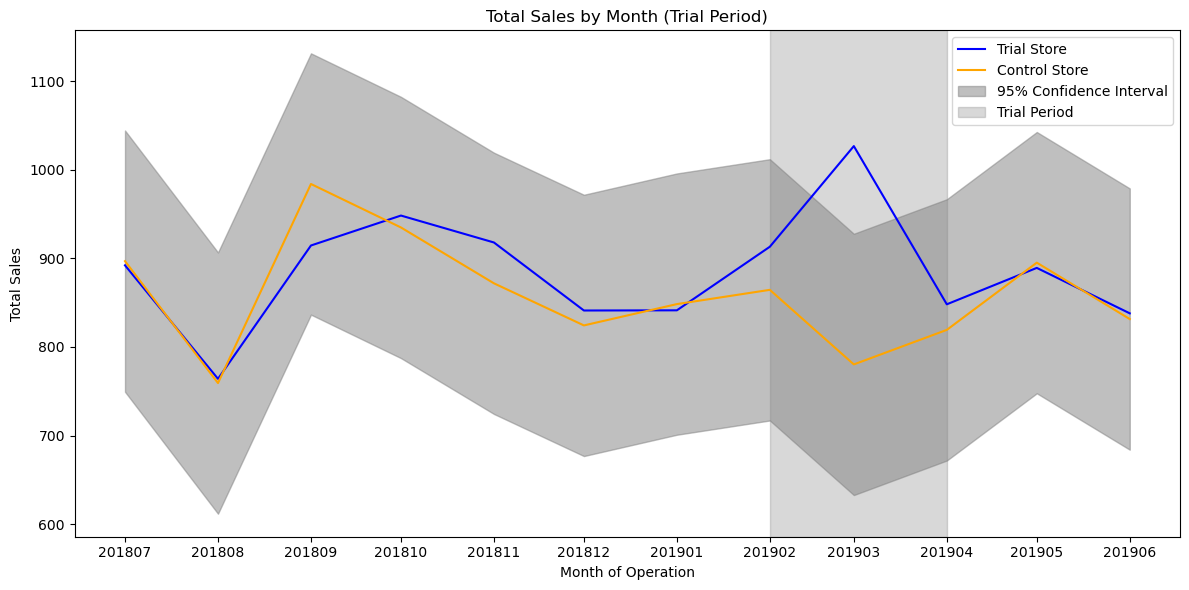

In [81]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['totSales'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['totSales'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['totSales'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['totSales'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Sales by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in one of the three trial
months.

## Total Customers

Scale Pre Trial Total Customers

In [82]:
# Calculate the scaling factor for control sales
scaling_factor = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['nCustomers'].sum() / \
                 pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['nCustomers'].sum()

# Apply the scaling factor to control store's sales
measure_over_time['scaledControlSales'] = measure_over_time.apply(
    lambda x: x['nCustomers'] * scaling_factor if x['STORE_NBR'] == control_store else x['nCustomers'],
    axis=1
)

Calculate the percentage difference between scaled control sales and trial store sales during the trial period

In [83]:
merged_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([trial_store, control_store])]
merged_sales = merged_sales.pivot_table(values='scaledControlSales', index='MONTH_ID', columns='STORE_NBR')

# Calculate the percentage difference between scaled control sales and trial sales
merged_sales['percentageDiff'] = ((merged_sales[trial_store] - merged_sales[control_store]) / merged_sales[control_store]) * 100

In [84]:
merged_sales.head(10)

STORE_NBR,86,155,percentageDiff
MONTH_ID,,,
201807,99.0,101.0,-1.980198
201808,94.0,91.0,3.296703
201809,103.0,103.0,0.000000
201810,109.0,108.0,0.925926
201811,100.0,101.0,-0.990099
201812,98.0,97.0,1.030928
201901,94.0,96.0,-2.083333
201902,107.0,95.0,12.631579
201903,115.0,94.0,22.340426


T-test For Trial Month

In [85]:
# Calculate the standard deviation of the percentage difference in the pre-trial period
std_dev = merged_sales.loc[merged_sales.index < 201902, 'percentageDiff'].std()

# Degrees of freedom is number of observations minus 1
degrees_of_freedom = 7

# Get the trial months of March and April
trial_months = merged_sales.loc[[201903, 201904], 'percentageDiff']

# Calculate t-values for the trial months
trial_months_t_values = trial_months / std_dev

# Find the 95th percentile of the t-distribution with the degrees of freedom
t_critical = t.ppf(0.95, degrees_of_freedom)

# Displaying the t-values and the t-critical value for March and April
trial_months_results = pd.DataFrame({
    'MONTH_ID': [201903, 201904],
    'tValue': trial_months_t_values,
    'tCritical': t_critical
})

trial_months_results


,MONTH_ID,tValue,tCritical
MONTH_ID,,,
201903,201903,11.660429,1.894579
201904,201904,3.163291,1.894579


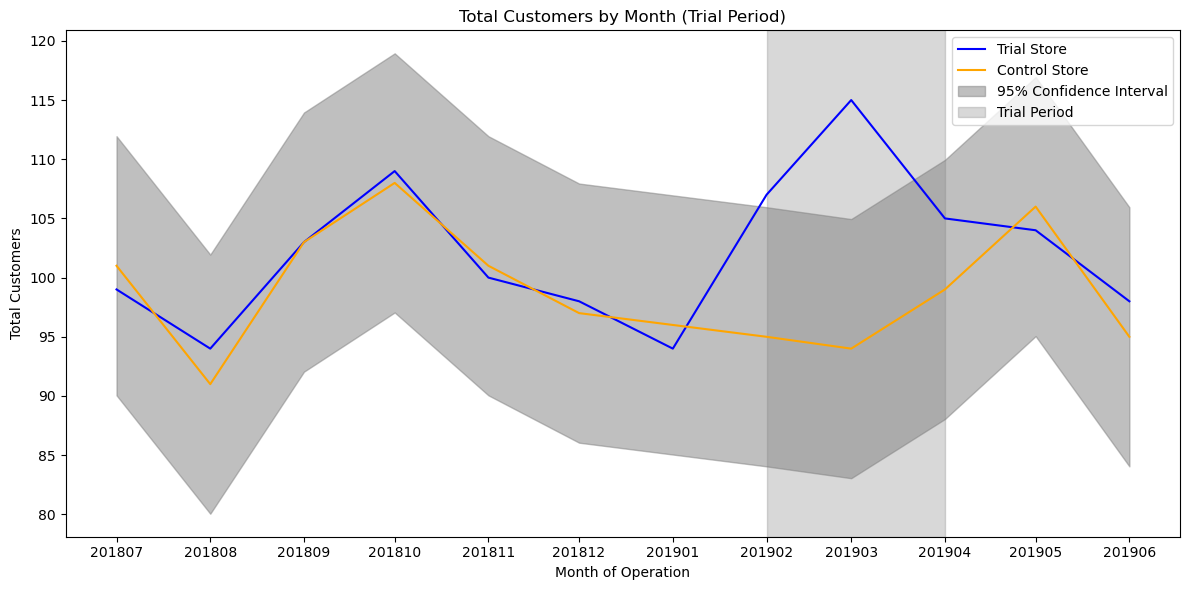

In [86]:
# Filter the DataFrame for the trial and control stores
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

# Make sure MONTH_ID is an integer for comparison
trial_data['MONTH_ID'] = trial_data['MONTH_ID'].astype(int)
control_data['MONTH_ID'] = control_data['MONTH_ID'].astype(int)

# Calculate the scaling factor for control store sales to match trial store sales pre-trial
scaling_factor = (trial_data[trial_data['MONTH_ID'] < 201902]['nCustomers'].sum() / 
                  control_data[control_data['MONTH_ID'] < 201902]['nCustomers'].sum())

# Apply scaling factor to control store sales
control_data['scaledTotSales'] = control_data['nCustomers'] * scaling_factor

# Calculate 95th percentile for control store scaled total sales
std_dev = control_data[control_data['MONTH_ID'] < 201902]['scaledTotSales'].std()
control_data['Control95'] = control_data['scaledTotSales'] + (std_dev * 2)
control_data['Control5'] = control_data['scaledTotSales'] - (std_dev * 2)

# Ensure the MONTH_ID is datetime format for plotting
control_data['MONTH_ID'] = pd.to_datetime(control_data['MONTH_ID'], format='%Y%m')
trial_data['MONTH_ID'] = pd.to_datetime(trial_data['MONTH_ID'], format='%Y%m')

# Plotting the sales data
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting trial store sales
ax.plot(trial_data['MONTH_ID'], trial_data['nCustomers'], label='Trial Store', color='blue')

# Plotting control store sales and confidence intervals
ax.plot(control_data['MONTH_ID'], control_data['scaledTotSales'], label='Control Store', color='orange')
ax.fill_between(control_data['MONTH_ID'], control_data['Control5'], control_data['Control95'], 
                color='gray', alpha=0.5, label='95% Confidence Interval')

# Highlighting the trial period
ax.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), 
           color='gray', alpha=0.3, label='Trial Period')

# Formatting the plot
ax.set_xticks(pd.date_range(start=control_data['MONTH_ID'].min(), end=control_data['MONTH_ID'].max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%Y%m'))
plt.title('Total Customers by Month (Trial Period)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Customers')
plt.legend()
plt.tight_layout()
plt.show()
